In [162]:
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import numpy as np
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import pandas as pd
%matplotlib inline

In [2]:
plt.style.use('seaborn-poster')

# Zodiacal Light

Using http://etc.stsci.edu/etc/input/acs/imaging/



In [3]:
# Zodiacal Light Background (from No EarthShine computation)
zod_bkg_f850lp = 20.714 / 400.  # e-/s/pix
zod_bkg_f475w = 27.214 / 400.  # e-/s/pix

In [4]:
# Subtract above from "Average Earthshine"
ave_earthshine_f850lp = (24.703 / 400.) - zod_bkg_f850lp
ave_earthshine_f475w = (34.248 / 400.) - zod_bkg_f475w

# EarthShine

## Load data from JIT files

In [5]:
jitf850lp = fits.open('../data/m49/raw/m49_f850lp_jit.fits')  # f850lp
jitf475w = fits.open('../data/m49/raw/m49_f475w_jit.fits')  # f475w

In [6]:
obsf475w_1 = fits.open('../data/m49/raw/m49_exp1_f475w_flc.fits')
obsf475w_2 = fits.open('../data/m49/raw/m49_exp2_f475w_flc.fits')
obsf850lp_1 = fits.open('../data/m49/raw/m49_exp1_f850lp_flc.fits')
obsf850lp_2 = fits.open('../data/m49/raw/m49_exp2_f850lp_flc.fits')

In [7]:
def get_starttime(time_obs):
    h,m,s = time_obs.split(':')
    return int(s) + 60*int(m) + 3600*int(h)

In [8]:
## "The observation log files share the same rootname as the observation they are associated with, except for the final character, which for observation log files is always a “j”"
## - http://www.stsci.edu/hst/HST_overview/documents/datahandbook/intro_ch62.html#104573

jitf850lp[1].header['EXPNAME'], obsf850lp_1[1].header['ROOTNAME']

('j8fs01x6j', 'j8fs01x6q')

In [9]:
jitf850lp[2].header['EXPNAME'], obsf850lp_2[1].header['ROOTNAME']

('j8fs01x8j', 'j8fs01x8q')

In [10]:
jitf475w[1].header['EXPNAME'], obsf475w_1[1].header['ROOTNAME']

('j8fs01xaj', 'j8fs01xaq')

In [11]:
jitf475w[2].header['EXPNAME'], obsf475w_2[1].header['ROOTNAME']

('j8fs01xcj', 'j8fs01xcq')

In [12]:
jitf475w[1].data.columns

ColDefs(
    name = 'Seconds'; format = 'E'; unit = 'seconds'
    name = 'V2_dom'; format = 'E'; unit = 'arcsec'
    name = 'V3_dom'; format = 'E'; unit = 'arcsec'
    name = 'V2_roll'; format = 'E'; unit = 'arcsec'
    name = 'V3_roll'; format = 'E'; unit = 'arcsec'
    name = 'SI_V2_AVG'; format = 'E'; unit = 'arcsec'
    name = 'SI_V2_RMS'; format = 'E'; unit = 'arcsec'
    name = 'SI_V2_P2P'; format = 'E'; unit = 'arcsec'
    name = 'SI_V3_AVG'; format = 'E'; unit = 'arcsec'
    name = 'SI_V3_RMS'; format = 'E'; unit = 'arcsec'
    name = 'SI_V3_P2P'; format = 'E'; unit = 'arcsec'
    name = 'RA'; format = 'D'; unit = 'degrees'
    name = 'DEC'; format = 'D'; unit = 'degrees'
    name = 'Roll'; format = 'D'; unit = 'degrees'
    name = 'LimbAng'; format = 'E'; unit = 'degrees'
    name = 'TermAng'; format = 'E'; unit = 'degrees'
    name = 'LOS_Zenith'; format = 'E'; unit = 'degrees'
    name = 'Latitude'; format = 'E'; unit = 'degrees'
    name = 'Longitude'; format = 'E'; unit = 

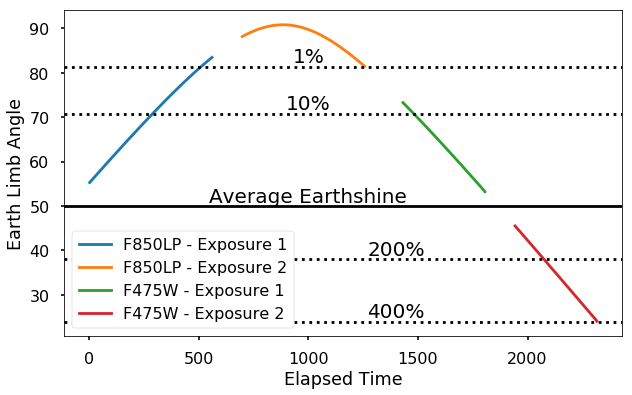

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(jitf850lp[1].data['SECONDS'] + get_starttime(obsf850lp_1[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf850lp[1].data['LIMBANG'], label='F850LP - Exposure 1')
ax.plot(jitf850lp[2].data['SECONDS'] + get_starttime(obsf850lp_2[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf850lp[2].data['LIMBANG'], label='F850LP - Exposure 2')
ax.plot(jitf475w[1].data['SECONDS'] + get_starttime(obsf475w_1[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf475w[1].data['LIMBANG'], label='F475W - Exposure 1')
ax.plot(jitf475w[2].data['SECONDS'] + get_starttime(obsf475w_2[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf475w[2].data['LIMBANG'], label='F475W - Exposure 2')
# ax.axhline(y=86.4, ls=':', color='k',)
# ax.text(1000, 86.4, '0.1%', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.axhline(y=81.4, ls=':', color='k',)
ax.text(1000, 81.4, '1%', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.axhline(y=70.8, ls=':', color='k',)
ax.text(1000, 70.8, '10%', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.axhline(y=50, ls='-', color='k',)
ax.text(1000, 50, 'Average Earthshine', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.axhline(y=38, ls=':', color='k',)
ax.text(1400, 38, '200%', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.axhline(y=24, ls=':', color='k',)
ax.text(1400, 24, '400%', fontsize=20, verticalalignment='bottom', horizontalalignment='center')
ax.legend(loc=0, framealpha=1.0)
ax.set_xlabel('Elapsed Time')
ax.set_ylabel('Earth Limb Angle')
fig.savefig('figures/m49_Earthshine.pdf')

In [14]:
96*60

5760

Text(0,0.5,'Terminator Angle')

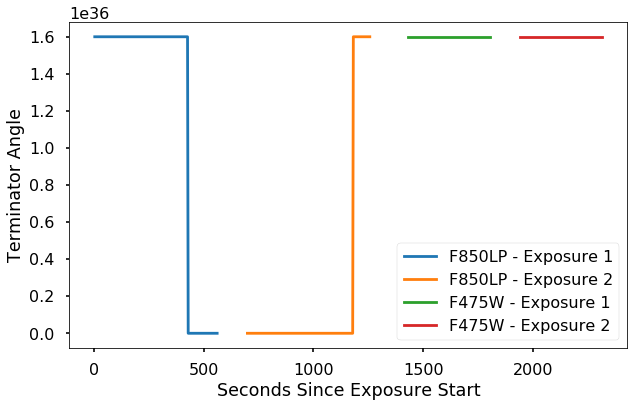

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(jitf850lp[1].data['SECONDS'] + get_starttime(obsf850lp_1[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf850lp[1].data['TERMANG'], label='F850LP - Exposure 1')
ax.plot(jitf850lp[2].data['SECONDS'] + get_starttime(obsf850lp_2[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf850lp[2].data['TERMANG'], label='F850LP - Exposure 2')
ax.plot(jitf475w[1].data['SECONDS'] + get_starttime(obsf475w_1[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf475w[1].data['TERMANG'], label='F475W - Exposure 1')
ax.plot(jitf475w[2].data['SECONDS'] + get_starttime(obsf475w_2[0].header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS']), jitf475w[2].data['TERMANG'], label='F475W - Exposure 2')
ax.legend(loc=0)
ax.set_xlabel('Seconds Since Exposure Start')
ax.set_ylabel('Terminator Angle')

In [16]:
jitf475w[2].data['LIMBANG'].min()

24.072699

In [17]:
limlimbangle, mags = np.loadtxt('../data/Earthshine_Levels.csv', unpack=True, delimiter=',')  # scraped from http://www.stsci.edu/hst/stis/documents/handbooks/currentIHB/c06_exptime6.html#337664

In [18]:
blah = limbangle.argsort()
limbangle = limbangle[blah]
mags = mags[blah]

In [19]:
mag_func = interp1d(limbangle, mags, kind='cubic', fill_value='extrapolate')

In [20]:
def flux_ratio(angle):
    baseline = mag_func(50.)
    mags = mag_func(angle)
    fluxes = 10.**(-.4 * (mags - baseline))
    return fluxes

In [21]:
flux_ratio(70.9)

0.09864973425731209

In [22]:
flux_ratio(81.4)

0.010084364135571459

In [23]:
flux_ratio(86.4)

0.0010171833428200597

Text(0,0.5,'EarthShine (V-band Mags / as^2)')

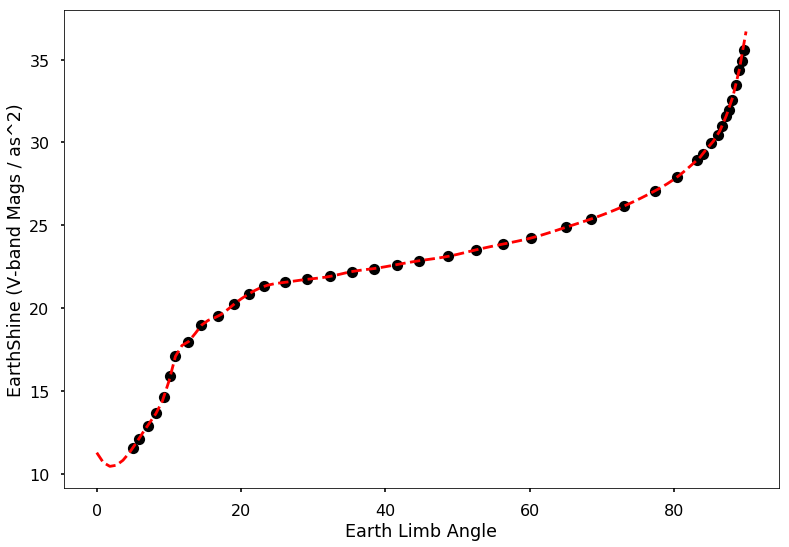

In [25]:
flux_ratio(24)

5.375071315931543

In [26]:
flux_ratio(50)

1.0

In [27]:
flux_ratio(38)

2.251182953619102

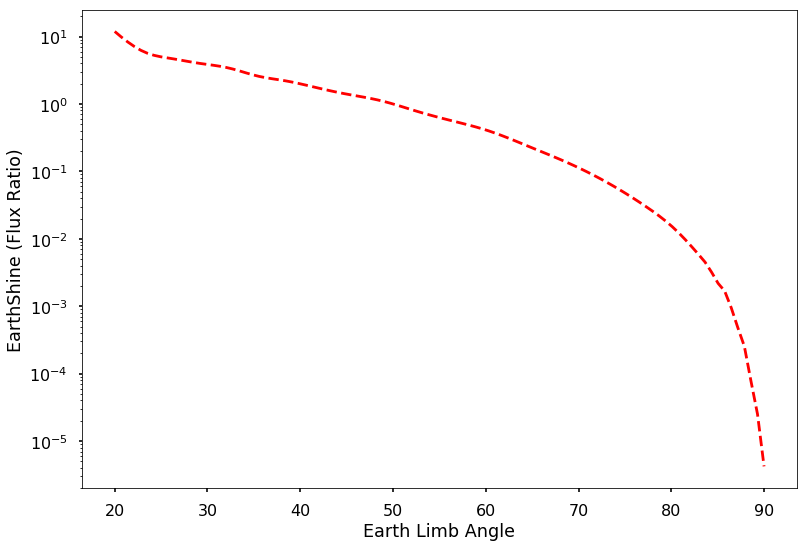

In [28]:
x = np.linspace(20, 90, 100)
plt.plot(x, flux_ratio(x), 'r--')
plt.xlabel('Earth Limb Angle')
plt.ylabel('EarthShine (Flux Ratio)')
plt.yscale('log')

In [29]:
def integrated_counts(angles, average_rate):
    fluxes = flux_ratio(angles) * average_rate  # e-/s/pix
    return trapz(fluxes, dx=3.0)   # e-/pix over integration

In [30]:
es_counts_f850lp_1 = integrated_counts(jitf850lp[1].data['LIMBANG'], ave_earthshine_f850lp)
es_counts_f850lp_1

0.9865515184960791

In [31]:
es_counts_f850lp_2 = integrated_counts(jitf850lp[2].data['LIMBANG'], ave_earthshine_f850lp)
es_counts_f850lp_2

0.005848258878354808

In [32]:
es_counts_f475w_1 = integrated_counts(jitf475w[1].data['LIMBANG'], ave_earthshine_f475w)
es_counts_f475w_1

2.091090090912285

In [33]:
es_counts_f475w_2 = integrated_counts(jitf475w[2].data['LIMBANG'], ave_earthshine_f475w)
es_counts_f475w_2

19.664179830804226

# Total the Sky

In [34]:
df = pd.DataFrame(data={'Earthshine(e-/pix)': [es_counts_f475w_1, es_counts_f475w_2, es_counts_f850lp_1, es_counts_f850lp_2],
                        'Zodiacal(e-/pix)': [zod_bkg_f475w * 375., zod_bkg_f475w * 375., zod_bkg_f850lp * 560., zod_bkg_f850lp * 560.]},
                  index=['F475W_1', 'F475W_2', 'F850LP_1', 'F850LP_2'])
df['Total(e-/pix)'] = df['Earthshine(e-/pix)'] + df['Zodiacal(e-/pix)']
df

,Earthshine(e-/pix),Zodiacal(e-/pix),Total(e-/pix)
F475W_1,2.091090,25.513125,27.604215
F475W_2,19.664180,25.513125,45.177305
F850LP_1,0.986552,28.999600,29.986152
F850LP_2,0.005848,28.999600,29.005448


The second F475W exposure seems extremely high, and is above the level of the observed sky noise.

Reccomend avoiding F475w exposure 2 !

# Orientation

In [300]:
m49 = SkyCoord.from_name('M49')
m49

<SkyCoord (ICRS): (ra, dec) in deg
    (187.4449917, 8.0004111)>

In [309]:
m49

<SkyCoord (ICRS): (ra, dec) in deg
    (187.4449917, 8.0004111)>

In [302]:
start_time = Time(obsf850lp_1[0].header['DATE-OBS'] +' '+ obsf850lp_1[0].header['TIME-OBS'])

In [303]:
start_time

<Time object: scale='utc' format='iso' value=2003-06-19 06:54:22.000>

In [310]:
def pointing(lat, lon, dt):
    time = start_time + dt*u.second
    print(time)
    hst = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=568*u.km)
    return m49.transform_to(AltAz(obstime=time, location=hst))

In [311]:
def plot_arrow(lat, lon, length, azimuth, map):
    u = length * np.sin(azimuth*np.pi / 180.)
    v = length * np.cos(azimuth*np.pi / 180.)
    map.quiver([lon], [lat], [u], [v], latlon=True, width=0.005, angles='xy', scale_units='xy', scale=1)

In [323]:
def plot_track(jithdu, obshdu, map):
    lons = jithdu.data['Longitude']
    lats = jithdu.data['Latitude']
    dts = jithdu.data['Seconds'] + get_starttime(obshdu.header['TIME-OBS']) - get_starttime(obsf850lp_1[0].header['TIME-OBS'])
    map.scatter(lons, lats, s=10, latlon=True)
    p1 = pointing(lats[0], lons[0], dt=dts[0])
    az1 = p1.az.value
    p2 = pointing(lats[-1], lons[-1], dt=dts[-1])
    az2 = p2.az.value
    r1 = 3000000.*np.sin(jithdu.data['LIMBANG'][0]*np.pi/180.)
    r2 = 3000000.*np.sin(jithdu.data['LIMBANG'][-1]*np.pi/180.)
    plot_arrow(lats[0], lons[0], r1, az1, map)
    plot_arrow(lats[-1], lons[-1], r2, az2, map)

/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


2003-06-19 06:54:24.949
2003-06-19 07:03:42.949
2003-06-19 07:06:00.949
2003-06-19 07:15:18.949
2003-06-19 07:18:13.949
2003-06-19 07:24:26.949
2003-06-19 07:26:44.949
2003-06-19 07:32:57.949


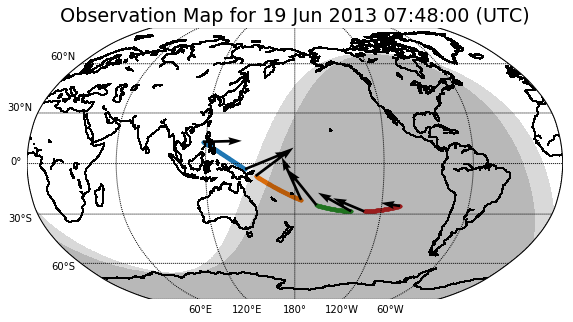

In [324]:
fig, ax = plt.subplots(figsize=(18, 5))
map = Basemap(projection='robin', lon_0=180)
map.drawcoastlines(antialiased=False)
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
for j, o in zip([jitf850lp[1], jitf850lp[2], jitf475w[1], jitf475w[2]],
               [obsf850lp_1[0], obsf850lp_2[0], obsf475w_1[0], obsf475w_2[0]]):
    plot_track(j, o, map)

# shade the night areas, with alpha transparency so the
# map shows through. Use current time in UTC.
date = datetime(2013, 6, 19, 6, 54)
CS=map.nightshade(date, alpha=0.15)
date = datetime(2013, 6, 19, 7, 48)
CS=map.nightshade(date, alpha=0.15)
ax.set_title('Observation Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
plt.savefig('figures/m49_orbitmap.pdf')

/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


                Geostationary, Orthographic or Azimuthal equidistant basemap
                2003-06-19 06:54:24.949
2003-06-19 07:03:42.949
2003-06-19 07:06:00.949
2003-06-19 07:15:18.949
2003-06-19 07:18:13.949
2003-06-19 07:24:26.949
2003-06-19 07:26:44.949
2003-06-19 07:32:57.949


Text(0.5,1,'Observation Map for 19 Jun 2013 07:48:00 (UTC)')

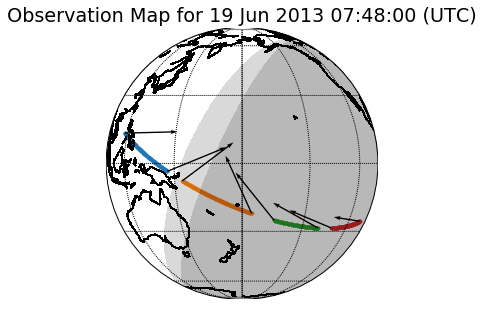

In [314]:
fig, ax = plt.subplots(figsize=(18, 5))
map = Basemap(projection='ortho', lon_0=180, lat_0=0, resolution='c')
map.drawcoastlines(antialiased=False)
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,30),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
for j, o in zip([jitf850lp[1], jitf850lp[2], jitf475w[1], jitf475w[2]],
               [obsf850lp_1[0], obsf850lp_2[0], obsf475w_1[0], obsf475w_2[0]]):
    plot_track(j, o, map)

# shade the night areas, with alpha transparency so the
# map shows through. Use current time in UTC.
date = datetime(2013, 6, 19, 6, 54)
CS=map.nightshade(date, alpha=0.15)
date = datetime(2013, 6, 19, 7, 48)
CS=map.nightshade(date, alpha=0.15)
ax.set_title('Observation Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
# plt.savefig('figures/m49_orbitmap.pdf')